이번 프로젝트는 다양한 모델들을 학습하여 Pose Estimation 결과를 비교해보는 과제이다. 간단한 Simplebaseline 모델부터 Stacked Hourglass 등의 모델까지 이미 구현된 모델의 코드로 학습 진행 경과 및 결과를 시각화하여 비교해보도록 하자.

과제목표

1. tfrecord를 활용한 데이터셋 구성과 전처리를 통해 프로젝트 베이스라인 구성을 확인하였다.
    - MPII 데이터셋을 기반으로 1epoch에 30분 이내에 학습가능한 베이스라인을 구축하였다.
2. simplebaseline 모델을 정상적으로 구현하였다.
    - simplebaseline 모델을 구현하여 실습코드의 모델을 대체하여 정상적으로 학습이 진행되었다.
3. Hourglass 모델과 simplebaseline 모델을 비교분석한 결과를 체계적으로 정리하였다.
    - 두 모델의 pose estimation 테스트결과 이미지 및 학습진행상황 등을 체계적으로 비교분석하였다.

---

<h2>데이터셋 준비 및 전처리<h2/>
<h5>모델의 훈련에 필요한 데이터는 MPII Human Pose Dataset을 사용하였다.<h5/>

In [1]:
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = 'C:/Users/ZAKAR/Documents/GitHub/AIFFEL/Exploration/Going_Deeper_CV/PoseEstimation'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'data', 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'data', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'data', 'validation.json')

이미지에 담겨 있는 사람들의 pose keypoint 정보들을 가지고 있는 JSON 파일은 Pose Estimation을 위한 label로 사용할 수 있다. JSON 파일을 파싱하는 함수는 tfrecords_mpii.py에서 호출하여 사용할 것이다.

<h3>TFRecord 파일 만들기<h3/>

큰 크기의 데이터셋을 다루게되면 학습 과정에서 GPU의 연산 속도보다 HDD I/O가 느리기 때문에 병목 현상이 발생하고 효율성이 떨어지는 문제가 생긴다. 이러한 문제를 해결하여 학습 속도를 향상시키려면 어떻게 해야 할까?
<br><br>
'데이터 직렬화'는 데이터에서 의미 있는 정보만을 추출해 나열함으로써 데이터의 크기를 줄이고 처리 속도를 높일 수 있는 방법이다. Tensorflow에서는 TFRecord 형태로 데이터셋을 변환하여 데이터 직렬화를 수행할 수 있다.

또한 대규모의 데이터를 다룰 때에는 데이터를 더 효율적으로 관리하고, 학습 속도를 높이며, 메모리 사용량을 줄이기 위하여 annotation을 shard로 나누는 방식을 사용한다. 이를 sharding이라고 하며 하나의 큰 데이터를 적절한 크기와 개수의 파일들로 나누어 준다.

In [2]:
from mpii_gtuV0hd.tfrecords_mpii import main

main()

2023-07-26 17:29:57,620	INFO worker.py:1621 -- Started a local Ray instance.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': './data/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': './data/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'center': [966.0, 340.0], 's

(pid=22832) Calling ray.init() again after it has already been called.


(build_single_tfrecord pid=7324) start to build tf records for ./tfrecords_mpii/train_0013_of_0064.tfrecords
(build_single_tfrecord pid=25572) finished building tf records for ./tfrecords_mpii/train_0001_of_0064.tfrecords
(build_single_tfrecord pid=27132) start to build tf records for ./tfrecords_mpii/train_0053_of_0064.tfrecords [repeated 52x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(build_single_tfrecord pid=14324) finished building tf records for ./tfrecords_mpii/train_0052_of_0064.tfrecords [repeated 47x across cluster]
Successfully wrote 25204 annotations to TF Records.


In [3]:
from mpii_gtuV0hd.preprocess import Preprocessor


preprocessed_data = Preprocessor()

(build_single_tfrecord pid=22500) finished building tf records for ./tfrecords_mpii/val_0004_of_0008.tfrecords
(build_single_tfrecord pid=27176) finished building tf records for ./tfrecords_mpii/val_0003_of_0008.tfrecords


<h2>모델 설계 및 학습<h2/>

이미 구현된 Hourglass 모델과 Simplebaseline 모델을 불러와서 준비한 데이터로 학습을 시켜보자.

Hourglass 모델과 Simplebaseline 모델의 구조는 다음과 같다.
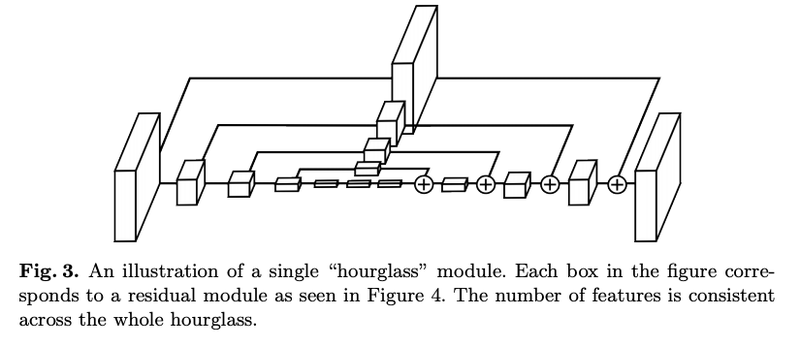
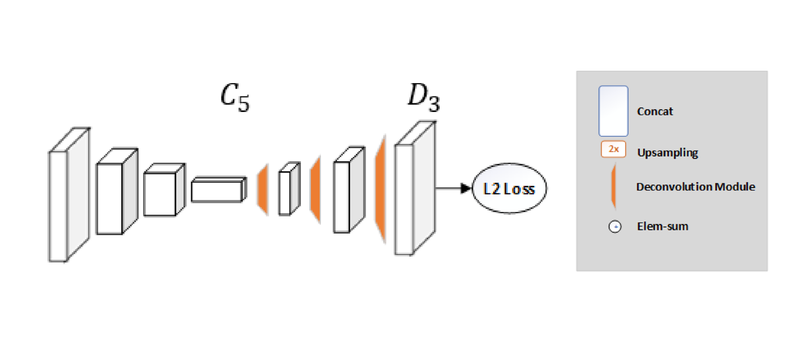

In [4]:
from mpii_gtuV0hd.train import train


train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 3
batch_size = 2
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate,
          num_heatmap, batch_size, train_tfrecords, val_tfrecords)

Start training...
Start epoch 1 with learning rate 0.0007


c:\Users\ZAKAR\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:461: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 10.5148659 epoch total loss 10.5148659
Trained batch 2 batch loss 10.3108768 epoch total loss 10.4128714
Trained batch 3 batch loss 9.89051056 epoch total loss 10.2387514
Trained batch 4 batch loss 8.35937881 epoch total loss 9.76890755
Trained batch 5 batch loss 8.43074799 epoch total loss 9.50127602
Trained batch 6 batch loss 8.34402657 epoch total loss 9.3084
Trained batch 7 batch loss 7.45185757 epoch total loss 9.04318
Trained batch 8 batch loss 8.31870842 epoch total loss 8.95262146
Trained batch 9 batch loss 7.89187 epoch total loss 8.83476
Trained batch 10 batch loss 8.06293106 epoch total loss 8.7575779
Trained batch 11 batch loss 8.0234108 epoch total loss 8.690835
Trained batch 12 batch loss 7.67045 epoch total loss 8.60580254
Trained batch 13 batch loss 7.56365108 epoch total loss 8.52563667
Trained batch 14 batch loss 7.64938593 epoch total loss 8.46304798
Trained batch 15 batch loss 7.35198212 epoch total loss 8.38

Hourglass 모델의 예측:


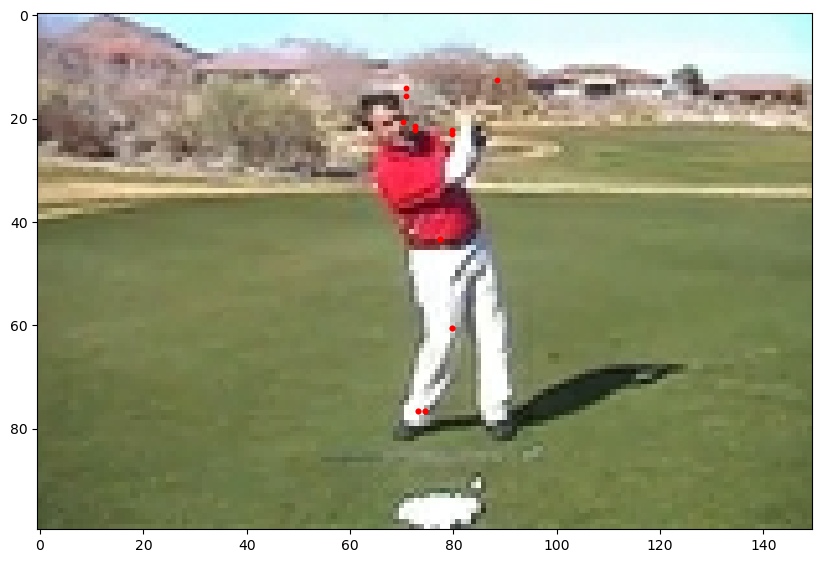

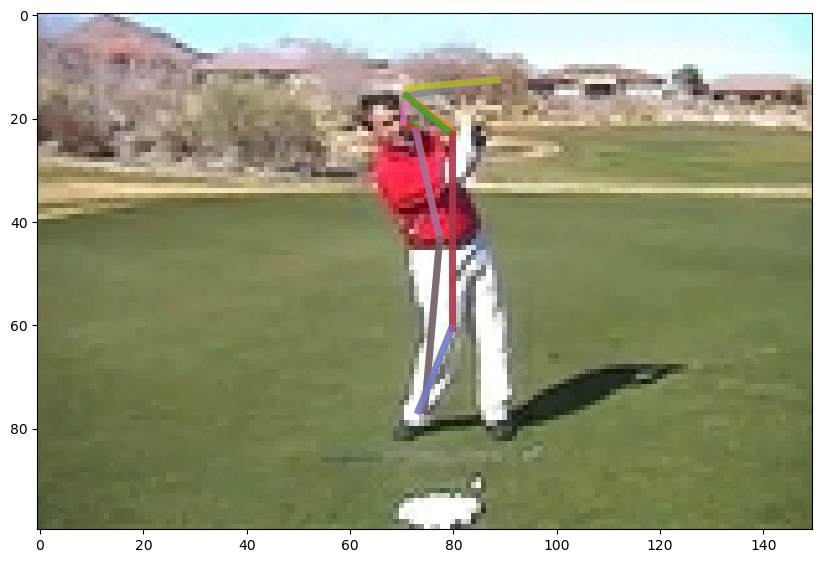

Simplebaseline 모델의 예측:


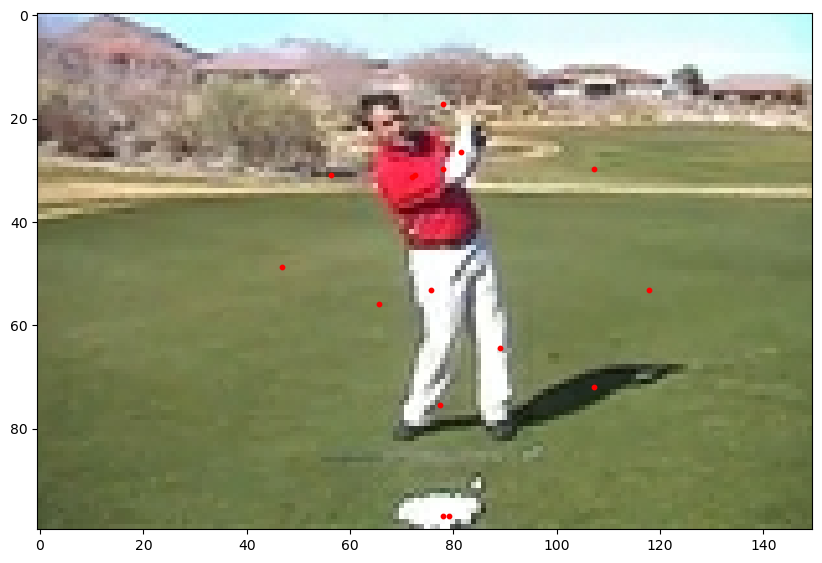

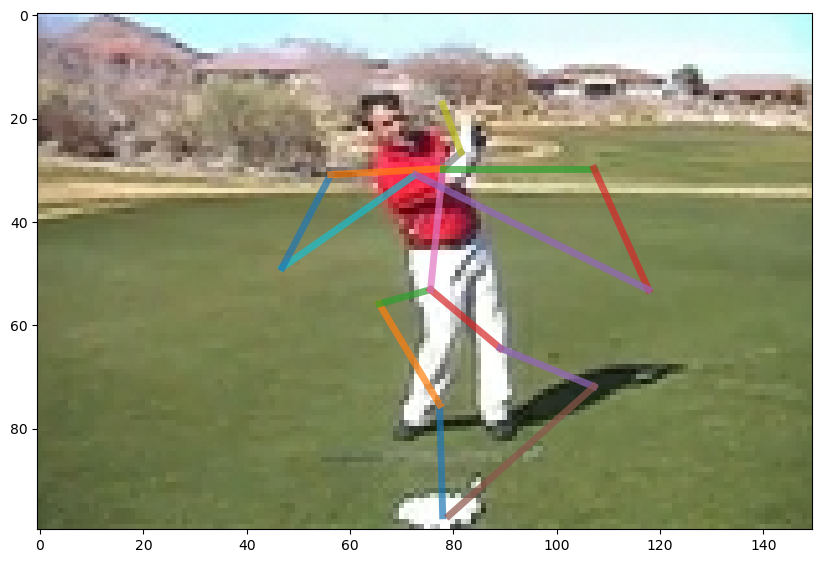

In [18]:
from mpii_gtuV0hd.test import predict_hour, predict_simple, draw_keypoints_on_image, draw_skeleton_on_image

print('Hourglass 모델의 예측:')
image, keypoints = predict_hour('./test_image.jpg')
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

print('Simplebaseline 모델의 예측:')
image_, keypoints_ = predict_simple('./test_image.jpg')
draw_keypoints_on_image(image_, keypoints_)
draw_skeleton_on_image(image_, keypoints_)

<h2>결과 분석 및 회고<h2/>

데이터셋의 규모와 모델 학습 환경의 한계로 인해 충분한 학습을 하지 못하여 두 모델 다 만족할만한 결과를 얻지 못한 점이 아쉬웠으며, 시간 관계 상 학습을 진행함에 따른 모델의 learning curve를 그리지 못한 부분도 아쉬움이 남았다.
<br><br>
만약 시간이 넉넉하였다면, 개인적으로 Hourglass, Simplebaseline 모델 뿐만 아니라 다른 최신 모델들도 같은 학습을 진행하였을 때 결과가 어떻게 나올지 궁금하다. 특히 올해 7월에 올라온 논문인 'Joint Coordinate Regression and Association For Multi-Person Pose Estimation, A Pure Neural Network Approach'(https://arxiv.org/abs/2307.01004)에서 다루는 JCRA 알고리즘은 한 번 시험해볼만 한 듯 하다.
<br><br>
간략하게 논문의 내용을 설명하자면, JCRA는 1-stage end-to-end 방식으로, 히트맵 없이 직접 키포인트 좌표를 출력할 수 있으며, 트랜스포머 쿼리를 통해 해당 키포인트의 연결을 수행하며, 69.2 mAP와 함께 최신의 bottom-up 알고리즘 보다 78% 빠른 inference acceleration을 달성하였다. 다음은 JCRA 알고리즘의 개요를 나타내는 이미지다.<br>
![제목 없음.png](<attachment:제목 없음.png>)
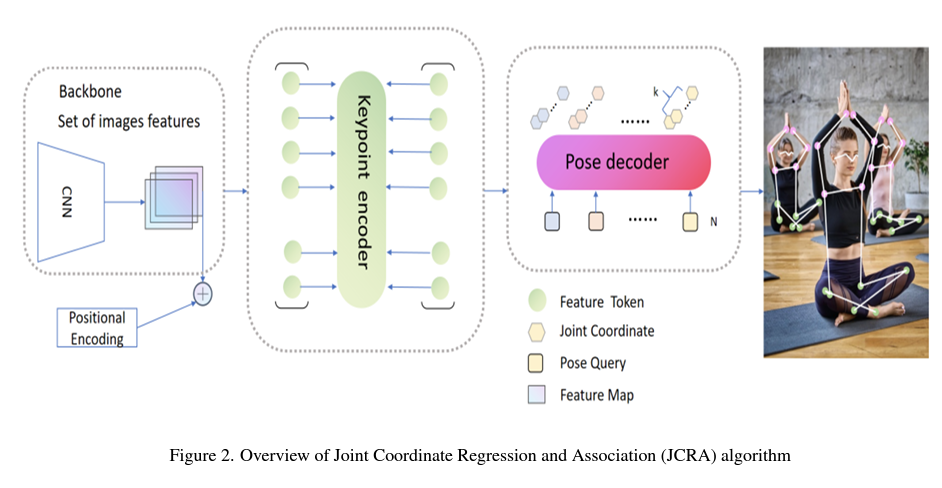